### Recurrent Neural Network

Recurrent Neural Networks (RNNs) are deep learning models, typically used to solve problems with sequential input data such as time series. What are they, and how do we use them in time series forecasting?

RNNs are a type of neural network that retains a memory of what it has already processed and thus can learn from previous iterations during its training.

RNNs is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence.

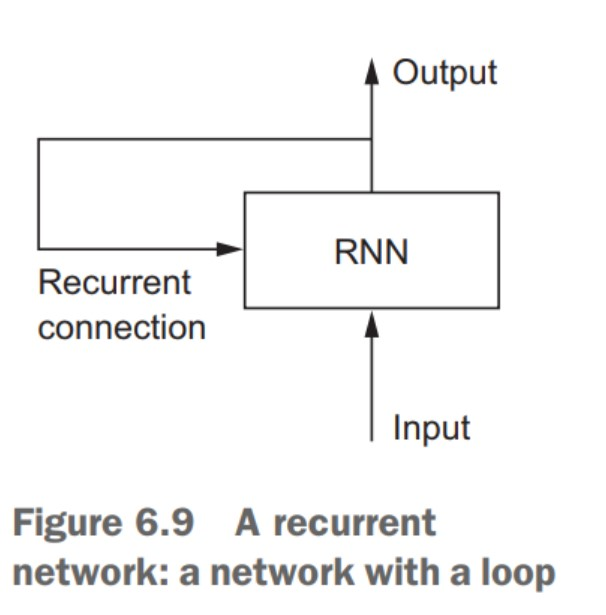

In [12]:
#Import all packages
from bisect import bisect_left
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from sklearn.decomposition import PCA
from ipywidgets import interact, FloatSlider

import timeit

import random
random.seed(10)

%matplotlib inline

Image(filename="Screenshot 2022-03-31 162302.jpg", width=400, height=400)



Artificial neural networks (ANNs), usually simply called neural networks (NNs), are computing systems inspired by the biological neural networks that constitute animal brains.

An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron receives a signal then processes it and can signal neurons connected to it. The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs.

A recurrent neural network, by contrast, retains a memory of what it has processed in its recent previous steps 

It makes recurrent connections by going through temporal feedback loops: the output of a preceding step is used as an input for the current process step. 

The hidden layers are located between the input and the output layer. In an RNN, they not only produce an output, but they also feed it back (“backpropagate” it) as an input for training the hidden layer on the next observation

If the RNN deals with time series, each period will be represented by a node, holding the period’s observational value.

An input value, when it is passed from its node on one layer to a node in another layer, travels along an edge (the connecting line) between the nodes. The edges are comparable to a brain’s synapses.

The receiving node sums all the inputs it receives to a total net input.

It feeds this net input into an activation function (aka transfer function) to compute the output: how much the node will contribute to the next layer.

The activation function’s output value is multiplied by a weight factor when it is sent out along an edge to a node in another layer, or over multiple edges to more than one receiving node.

The calibration mechanism a recurrent neural network applies is described by two terms you will encounter in most RNN descriptions:

backpropagation through time (BPTT) aka temporal loops;
and gradient descent.

When the network generates prediction values, it also computes the prediction error, the deviation from the training dataset. The network seeks to minimize the error by adjusting its internal weights during training. Backpropagation calculates the partial derivatives of the error with respect to the weights. Then the RNN recalibrates the weights, up or down, based on the partial derivatives.


#### A simplified sequence of the RNN’s process steps goes as follows:

It does a forward pass and computes the prediction errors to obtain the loss values on the training dataset and on the validation set.

It calculates the gradients at each layer, and backpropagates the errors, back across t timesteps. Then it updates the weights; and loops around to another forward pass.

The fitting process of the RNN, so that it minimizes the deviation of its output from the actual observations in the training dataset, is called mapping.

The cost function (aka loss, error, or objective function) measures the prediction error of the network as a number, a scalar. The goal of the RNN is to minimize the cost function. Prediction accuracy metrics such as the mean squared error MSE or root mean squared error RMSE, which we know from other time series methods, can serve as cost functions


Then the RNN investigates how the total error is spread out over all the weights in the network. It finds their individual contributions to the total error by calculating partial derivatives, aka gradients (‘slopes’). The loss function includes a multitude of weights. The partial derivative with respect to a certain weight reveals how that particular weight affects the total error.

In [6]:
pip install tensorflow==1.2.0 --ignore-installed
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SyntaxError: invalid syntax (<ipython-input-6-1f2ebb43c83c>, line 1)

In [7]:
 pip3 show tensorflow

SyntaxError: invalid syntax (<ipython-input-7-76eab10d50ab>, line 1)